In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
gbpusd = pd.read_csv("/home/volatily/market_data/GBPUSD_Daily_20160103_20240131.csv",sep="\t")

In [13]:
#Rename the columns
gbpusd.rename(columns={"<DATE>":"Date","<OPEN>":"Open","<HIGH>":"High","<LOW>":"Low","<CLOSE>":"Close","<TICKVOL>":"TickVol","<VOL>":"Vol","<SPREAD>":"Spread"},inplace=True)

In [14]:
#Define how far into the future we want to forecast
look_ahead = 20

In [15]:
#This column will help us with our plots
gbpusd["Future Close"] = gbpusd["Close"].shift(-look_ahead)
#Let's mark the normal target
#If price rises, our target will be 1
#If price falls, our target will be 0
gbpusd["Price Target"] = 0
#Let's mark the new target
#If price makes a higher high, we will label 1
#If price makes a lower low, we will label 2
#If price fails to make either, we will label 3
gbpusd["New Target"] = 0

In [16]:
#Labelling the data
#If the future close was less than the current close, price depreciated, label 0
gbpusd.loc[gbpusd["Close"] > gbpusd["Close"].shift(-look_ahead),"Price Target"] = 0
#If the future close was greater than the current close, price depreciated, label 1
gbpusd.loc[gbpusd["Close"] < gbpusd["Close"].shift(-look_ahead),"Price Target"] = 1
#If price makes a higher high our label will be 1
gbpusd.loc[gbpusd["Close"].shift(-look_ahead) > gbpusd["High"],"New Target"] = 1
#If price makes a lower low our label will be 2
gbpusd.loc[gbpusd["Close"].shift(-look_ahead) < gbpusd["Low"],"New Target"] = 2
#Otherwise our label will be 3 
gbpusd.loc[(gbpusd["Close"].shift(-look_ahead) > gbpusd["Low"]) & (gbpusd["Close"].shift(-look_ahead) < gbpusd["High"]),"New Target"] = 3

In [17]:
#Drop the last look ahead rows
gbpusd = gbpusd[:-look_ahead]

In [18]:
gbpusd

Date     Open     High      Low    Close  TickVol           Vol  \
0     2016.01.03  1.47306  1.47445  1.47260  1.47352     3033    2242024000   
1     2016.01.04  1.47350  1.48152  1.46626  1.47111   139435  122985072000   
2     2016.01.05  1.47112  1.47250  1.46374  1.46731   126400  124661622000   
3     2016.01.06  1.46730  1.46795  1.46016  1.46275   144096  131911272000   
4     2016.01.07  1.46274  1.46398  1.45327  1.46214   155176  142476027000   
...          ...      ...      ...      ...      ...      ...           ...   
2483  2024.01.03  1.26224  1.26766  1.26157  1.26731   148862             0   
2484  2024.01.04  1.26731  1.27299  1.26569  1.26810   126146             0   
2485  2024.01.05  1.26811  1.27710  1.26110  1.27167   153452             0   
2486  2024.01.07  1.26951  1.27188  1.26951  1.27171     1592             0   
2487  2024.01.08  1.27170  1.27671  1.26732  1.27410   111724             0   

      Spread  Future Close  Price Target  New Target  
0         11       1.43410             0           2  
1         11       1.42432             0           2  
2         11       1.43576             0           2  
3         11       1.42422             0           2  
4         11       1.42435             0           2  
...      ...           ...           ...         ...  
2483       0       1.27029             1           1  
2484       0       1.26966             1           3  
2485       0       1.27118             0           3  
2486       0       1.26943             0           2  
2487       0       1.26792             0           3  

[2488 rows x 11 columns]

<Axes: xlabel='Close', ylabel='High'>

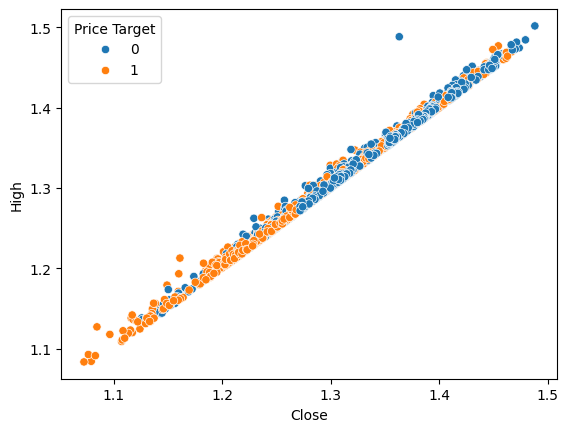

In [19]:
#Plot a scattor plot so we can see if there may be any relationship between the close and the high
sns.scatterplot(data=gbpusd,x="Close",y="High",hue="Price Target")

<Axes: xlabel='Close', ylabel='Low'>

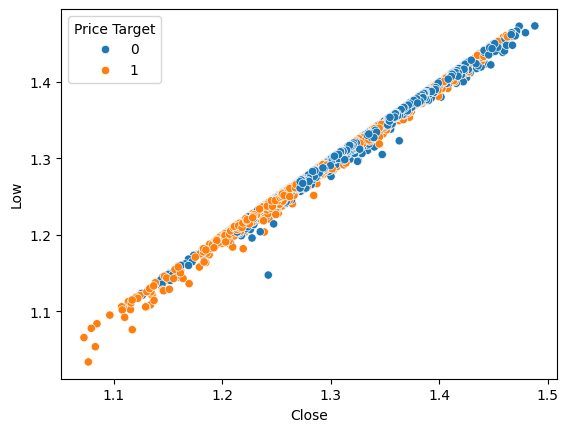

In [79]:
#Plot a scattor plot so we can see if there may be any relationship between the close and the low
sns.scatterplot(data=gbpusd,x="Close",y="Low",hue="Price Target")

<Axes: xlabel='Close', ylabel='Low'>

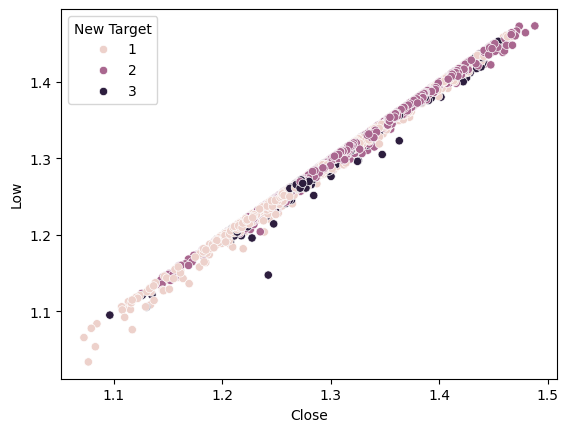

In [95]:
#Plot a scattor plot so we can see if there may be any relationship between the close and the low
sns.scatterplot(data=gbpusd,x="Close",y="Low",hue="New Target")

<Axes: xlabel='Close', ylabel='Future Close'>

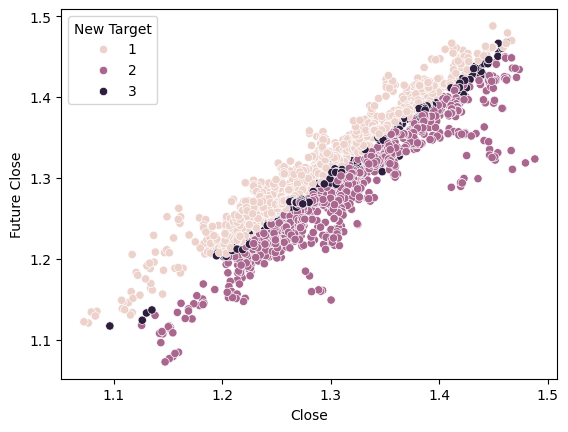

In [21]:
#Plot a scattor plot so we can see if there may be any relationship between the close and the low
sns.scatterplot(data=gbpusd,x="Close",y="Future Close",hue="New Target")

<Axes: xlabel='Close', ylabel='Future Close'>

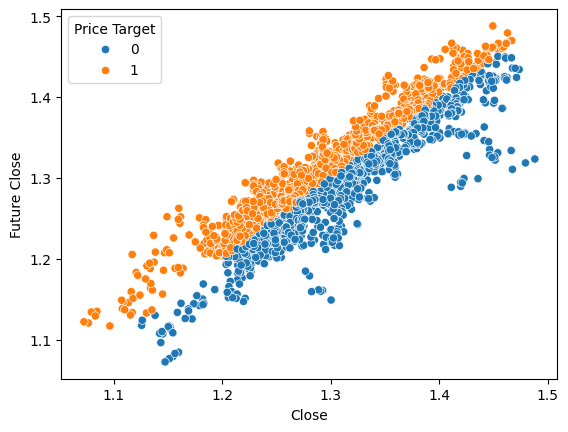

In [22]:
#Plot a scattor plot so we can see if there may be any relationship between the close and the low
sns.scatterplot(data=gbpusd,x="Close",y="Future Close",hue="Price Target")

In [31]:
#Let's get a group of different models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
#Import cross validation libraries
from sklearn.model_selection import TimeSeriesSplit
#Import accuracy metrics
from sklearn.metrics import accuracy_score
#Import preprocessors
from sklearn.preprocessing import RobustScaler

In [32]:
#Number of KNeighbors 
neighbors = 3

In [33]:
#Splits
splits = 10
gap = look_ahead

In [105]:
#Store each of the models we need
cols = ["AdaBoostClassifier","Linear DiscriminantAnalysis","Bagging Classifier","Random Forest Classifier","KNeighborsClassifier","Neural Network Small","Neural Network Large"]
models = [AdaBoostClassifier(),LinearDiscriminantAnalysis(),BaggingClassifier(n_jobs=-1),RandomForestClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),MLPClassifier(hidden_layer_sizes=(5,2),early_stopping=True,max_iter=1000),MLPClassifier(hidden_layer_sizes=(20,10),early_stopping=True,max_iter=1000)]
#Create data frames to store our accuracy with different models on different targets
index = np.arange(0,splits)
price_target = pd.DataFrame(columns=cols,index=index)
new_target = pd.DataFrame(columns=cols,index=index)

In [106]:
#Create the tscv splits
tscv = TimeSeriesSplit(n_splits=splits,gap=gap)

In [109]:
#Define the parameters
predictors = ["Open","High","Low","Close"]
target = "Price Target"

In [110]:
#Now we perform cross validation
for j in (np.arange(len(models))):
    #We need to train each model
    model = models[j]
    for i,(train,test) in enumerate(tscv.split(gbpusd)):
        #Scale the data
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(gbpusd.loc[train[0]:train[-1],predictors])
        scaler = RobustScaler()
        X_test_scaled = scaler.fit_transform(gbpusd.loc[test[0]:test[-1],predictors])
        #Train the model
        model.fit(X_train_scaled,gbpusd.loc[train[0]:train[-1],target])
        #Measure the accuracy
        price_target.iloc[i,j] = accuracy_score(gbpusd.loc[test[0]:test[-1],target],model.predict(X_test_scaled))

Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

In [111]:
#Calculate the mean for each column when predicting price 
for i in np.arange(0,len(models)):
    print(f"{cols[i]} achieved accuracy: {price_target.iloc[:,i].mean()}")

AdaBoostClassifier achieved accuracy: 0.5190265486725664
Linear DiscriminantAnalysis achieved accuracy: 0.5579646017699115
Bagging Classifier achieved accuracy: 0.5256637168141592
Random Forest Classifier achieved accuracy: 0.5371681415929204
KNeighborsClassifier achieved accuracy: 0.536283185840708
Neural Network Small achieved accuracy: 0.49115044247787604
Neural Network Large achieved accuracy: 0.5778761061946902


In [112]:
#Calculate the mean for each column when predicting the new target
for i in np.arange(0,len(models)):
    print(f"{cols[i]} achieved accuracy: {new_target.iloc[:,i].mean()}")

AdaBoostClassifier achieved accuracy: 0.4539823008849558
Linear DiscriminantAnalysis achieved accuracy: 0.4668141592920355
Bagging Classifier achieved accuracy: 0.43053097345132746
Random Forest Classifier achieved accuracy: 0.4601769911504424
KNeighborsClassifier achieved accuracy: 0.465929203539823
Neural Network Small achieved accuracy: 0.34823008849557524
Neural Network Large achieved accuracy: 0.476991150442478


In [126]:
#Calculate the change in performance for each model
for i in np.arange(0,len(models)):
    print(f"{cols[i]} accuracy changed by: {(new_target.iloc[:,i].mean() - price_target.iloc[:,i].mean())/(new_target.iloc[:,i].mean()) * 100}%")

AdaBoostClassifier accuracy changed by: -14.32748538011695%
Linear DiscriminantAnalysis accuracy changed by: -19.526066350710863%
Bagging Classifier accuracy changed by: -22.09660842754366%
Random Forest Classifier accuracy changed by: -16.730769230769248%
KNeighborsClassifier accuracy changed by: -15.099715099715114%
Neural Network Small accuracy changed by: -41.04193138500632%
Neural Network Large accuracy changed by: -21.1502782931354%


In [77]:
new_target

AdaBoostClassifier Linear DiscriminantAnalysis Bagging Classifier  \
0           0.513274                     0.50885           0.429204   
1           0.442478                    0.455752           0.486726   
2           0.389381                    0.415929           0.438053   
3           0.446903                    0.517699           0.420354   
4           0.513274                    0.517699           0.429204   
5           0.402655                    0.389381           0.424779   
6           0.442478                    0.446903           0.455752   
7           0.389381                    0.464602           0.451327   
8           0.526549                    0.433628           0.477876   
9           0.526549                    0.517699           0.380531   

  Random Forest Classifier KNeighborsClassifier Neural Network Small  \
0                 0.429204             0.460177             0.314159   
1                 0.469027              0.49115             0.557522   
2                 0.460177             0.415929             0.681416   
3                 0.513274             0.522124             0.469027   
4                      0.5             0.495575             0.389381   
5                  0.40708             0.446903             0.181416   
6                 0.486726             0.438053             0.128319   
7                 0.438053             0.442478             0.106195   
8                 0.486726             0.495575             0.530973   
9                 0.402655             0.451327             0.561947   

  Neural Network Large  
0             0.477876  
1             0.495575  
2             0.353982  
3             0.570796  
4             0.513274  
5             0.367257  
6              0.49115  
7             0.274336  
8              0.49115  
9             0.570796

In [78]:
price_target

AdaBoostClassifier Linear DiscriminantAnalysis Bagging Classifier  \
0           0.579646                    0.539823           0.477876   
1           0.539823                    0.615044           0.446903   
2           0.424779                    0.553097           0.570796   
3           0.610619                    0.588496           0.473451   
4           0.610619                    0.641593           0.570796   
5           0.389381                    0.424779           0.424779   
6           0.535398                    0.610619           0.557522   
7           0.442478                    0.477876           0.522124   
8           0.561947                    0.553097           0.535398   
9           0.495575                    0.575221           0.495575   

  Random Forest Classifier KNeighborsClassifier Neural Network Small  \
0                 0.473451             0.486726              0.39823   
1                 0.566372             0.566372             0.606195   
2                 0.539823                  0.5             0.752212   
3                 0.632743             0.615044             0.433628   
4                 0.584071             0.623894             0.477876   
5                 0.442478             0.455752             0.190265   
6                 0.548673             0.530973             0.433628   
7                 0.530973             0.530973             0.336283   
8                 0.539823             0.544248             0.420354   
9                  0.49115              0.50885             0.482301   

  Neural Network Large  
0             0.402655  
1             0.393805  
2             0.579646  
3             0.584071  
4             0.522124  
5              0.49115  
6             0.632743  
7             0.699115  
8             0.517699  
9             0.623894

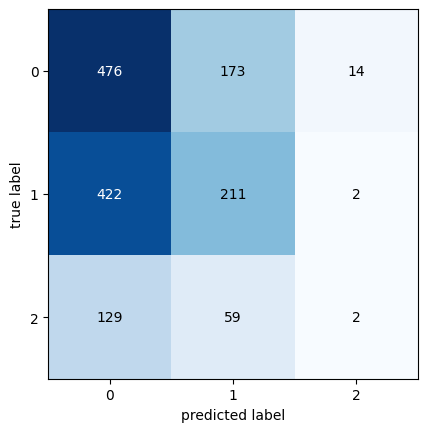

In [115]:
#Let's continue analysing the performance of our best model Linear Discriminant Analysis
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
model = LinearDiscriminantAnalysis()
model.fit(gbpusd.loc[0:1000,predictors],gbpusd.loc[0:1000,"New Target"])
cm = confusion_matrix(y_target=gbpusd.loc[1000:,"New Target"],y_predicted=model.predict(gbpusd.loc[1000:,predictors]))
fig , ax = plot_confusion_matrix(cm)

In [116]:
#Now let us perform feature selection
from mlxtend.feature_selection import SequentialFeatureSelector

In [120]:
#Forward feature selection 
forward_feature_selection = SequentialFeatureSelector(LinearDiscriminantAnalysis(),
                                                     k_features =(1,4),
                                                     forward=True,
                                                     verbose=2,
                                                     scoring="accuracy",
                                                     cv=5,
                                                     n_jobs=-1).fit(gbpusd.loc[:,predictors],gbpusd.loc[:,"New Target"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished

[2024-07-23 00:20:12] Features: 1/4 -- score: 0.5208512116877975[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished

[2024-07-23 00:20:13] Features: 2/4 -- score: 0.5132223057218815[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2024-07-23 00:20:13] Features: 3/4 -- score: 0.5084006044297915[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2024-07-23 00:20:13] Features: 4/4 -- score: 0.5011716887671411

In [121]:
#Best feature
forward_feature_selection.k_feature_names_

('Open',)

In [88]:
#Update the predictors and target
predictors = ["Open"]
target = "New Target"
best_features_for_new_target = pd.DataFrame(columns=["Linear Discriminant Analysis"],index=index)

In [89]:
#Now we perform cross validation
for i,(train,test) in enumerate(tscv.split(gbpusd)):
    #First initialize the model
    model = LogisticRegression()
    #Train the model
    model.fit(gbpusd.loc[train[0]:train[-1],predictors],gbpusd.loc[train[0]:train[-1],target])
    #Measure the accuracy
    best_features_for_new_target.iloc[i,0] = accuracy_score(gbpusd.loc[test[0]:test[-1],target],model.predict(gbpusd.loc[test[0]:test[-1],predictors]))

In [90]:
best_features_for_new_target

Linear Discriminant Analysis
0                      0.60177
1                     0.455752
2                     0.300885
3                     0.473451
4                     0.526549
5                     0.323009
6                      0.49115
7                     0.473451
8                     0.530973
9                     0.477876

In [91]:
#New accuracy only using the open price
best_features_for_new_target.iloc[:,0].mean()

0.46548672566371685

In [122]:
#Drop in performance
(best_features_for_new_target.iloc[:,0].mean() - new_target.loc[:,"Linear DiscriminantAnalysis"].mean())

-0.0013274336283186638